[Group 1 Galaxies](#1)
[Group 2 Galaxies](#2)
[Group 3 Galaxies](#3)
[Group 4 Galaxies](#4)
[Group 5 Galaxies](#5)
[Group 6 Galaxies](#6)

### This code provides galaxy size prdictions using only halo features and input and per independent datasets divided by 6 galaxy morphologies: 

### Groups 1, 2, 3, 4, 5 and 6 (ellipticals)
It also provides one single figure containing the prediction vs true values for all bins. Similarly, it provides one single figure containing the learning curves for all bins.

In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor


In [2]:
import target_predicting_ML_functions_and_feature_ranking as functions
import RF_target_predicting_and_learning_curves_functions as tp_lc_functions

In [3]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    fig, ax = plt.subplots(figsize=(7, 5))
#     plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("# of training examples",fontsize = 14)
 
    ax.set_ylabel("R2 score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    ax.legend(loc="best",fontsize = 12)
    return fig

#### <font color='violet'> ML modelling with 33 galaxy and halo features; df from v5 used here


#### Read the normalized 31-feature dataset (see explanations in related doc 'TNG-SAM 33-feature analysis')

In [4]:
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

#### Add the column 'BulgeMstar_ratio' defined as Bulge mass / Stellar mass, to be used as a proxy for galaxy morphology

In [5]:
df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']


In [6]:
df_normalized_31.shape

(35390, 33)

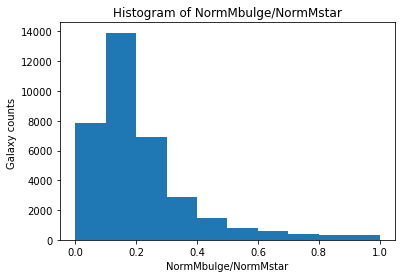

In [7]:
plt.hist(df_normalized_31['BulgeMstar_ratio'])
plt.title('Histogram of NormMbulge/NormMstar')
plt.xlabel('NormMbulge/NormMstar')
plt.ylabel('Galaxy counts ')
# plt.savefig('Histogram of GalpropNormMbulgebyNormMstar.jpg', dpi=500)

plt.show()

#### Define the 6 morphology groups by increasing Mbulge/Mstar ratio

In [8]:
# 7,865 galaxies in df_1
df_1 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']<=0.10] 

# 13,921 galaxies in df_2
df_2 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.10) & (df_normalized_31.BulgeMstar_ratio <= 0.20)] 

# 6,880 galaxies in df_3
df_3 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.20) & (df_normalized_31.BulgeMstar_ratio <= 0.30)] 

# 2,858 galaxies in df_4
df_4 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.30) & (df_normalized_31.BulgeMstar_ratio <= 0.40)] 

# 1,444 galaxies in df_5
df_5 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.40) & (df_normalized_31.BulgeMstar_ratio <= 0.50)] 

# 2,422 galaxies in df_6
df_6 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']>0.50] 


## <font color='purple'> <a id =0> </a> <br> All morphologies

In [12]:
X_all = df_normalized_31.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_all = df_normalized_31.loc[:,'GalpropNormHalfRadius']

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.3985 {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}
RF Accuracy: 0.40 (+/- 0.03)


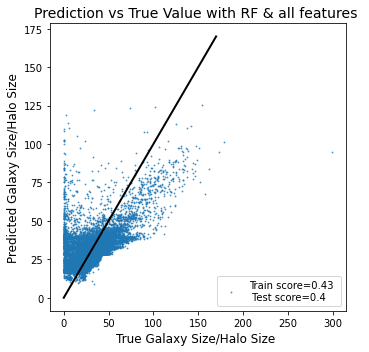

Elapsed time to compute the importances: 0.029 seconds
Elapsed time to compute the importances: 1.376 seconds


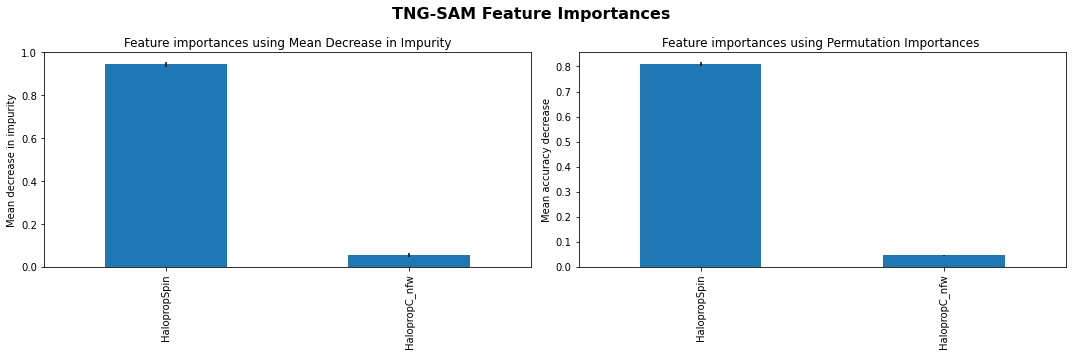

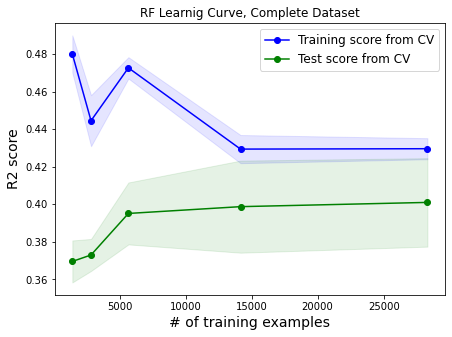

Elapsed time to run RF func and Learning Curves on the complete dataset: 67.376 seconds


In [13]:
# this code takes ~67.4 seconds to run on the complete dataset galaxies with ~35,000 entries
start_time = time.time()

RF_results_lc_all = tp_lc_functions.target_predicting_RF_function(X_all, y_all, 'RF Learnig Curve, Complete Dataset')

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func and Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

In [14]:
lc_all = RF_results_lc_all[4]

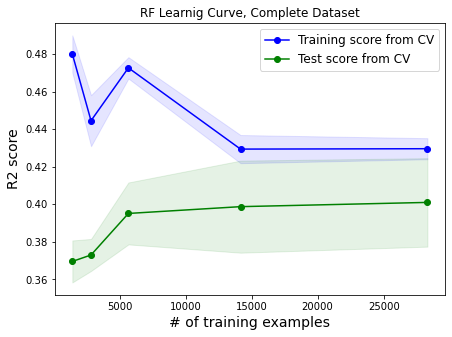

In [15]:
lc_all

In [36]:
# lc_all.savefig('RF Complete Dataset Learning Curve.jpeg', dpi=500)


## <font color='purple'> <a id =1> </a> <br> Group 1 Galaxies: B/Mstar <= 0.1

In [17]:
X_1 = df_1.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_1 = df_1.loc[:,'GalpropNormHalfRadius']

In [18]:
regr_RF = RandomForestRegressor(random_state=0)

# Use best params only: Best params, best score: 0.9850 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}

# number of trees in random forest
n_estimators = [20,50,100]
# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [2],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Grid search of parameters
rfr_grid_1 = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid_1.fit(X_1, y_1)

print('Best params, best score:', "{:.4f}".format(rfr_grid_1.best_score_), \
    rfr_grid_1.best_params_)
# define trainscore according to best model
best_RF_1=rfr_grid_1.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

best_RF_trainscore_1=rfr_grid_1.cv_results_['mean_train_score'][rfr_grid_1.best_index_]

# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_RF_1 = cross_val_predict(best_RF_1, X_1, y_1, cv = KFold(n_splits=5, shuffle=True, random_state=10))

# find prediction scores of each of the cross validation fold
scores_RF_1 = cross_val_score(best_RF_1, X_1, y_1, cv = KFold(n_splits=5, shuffle=True, random_state=10))
print("Group 1 RF Accuracy: %0.2f (+/- %0.2f)" % (scores_RF_1.mean(), scores_RF_1.std() * 2))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params, best score: 0.7280 {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}
Group 1 RF Accuracy: 0.73 (+/- 0.04)


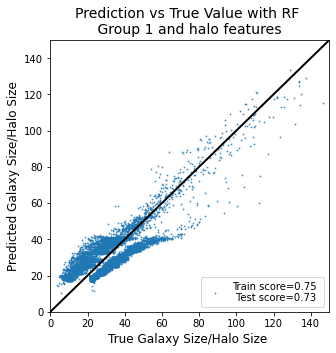

In [19]:
# Plot the figure
fig_prediction_1, ax = plt.subplots(figsize=(5, 5))

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_1, 2),round(scores_RF_1.mean(), 2) )
ax = plt.subplot()
ax.scatter(y_1, y_pred_RF_1, s=3, marker='.', alpha=0.7, label=label)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax.set_title('Prediction vs True Value with RF \n Group 1 and halo features ', fontsize=14)
ax.set_xlabel('True Galaxy Size/Halo Size ', fontsize=12)
ax.set_ylabel('Predicted Galaxy Size/Halo Size', fontsize=12)
ax.legend(loc='lower right')
# fig_prediction_1.savefig('Group1_RF_pred_vs_true_w_all_features.jpeg', dpi=500)
plt.show()

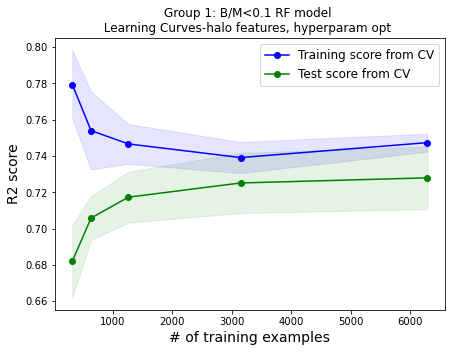

In [20]:
lc_1 = plot_learning_curve(best_RF_1, 'Group 1: B/M<0.1 RF model \n Learning Curves-halo features, hyperparam opt  ', X_1, y_1, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# lc_1.savefig('LC_RF_Group1_all_feat.jpeg', dpi=500)

#### Run the same above code with 10 most important features

## <font color='purple'> <a id =2> </a> <br>Group 2 Galaxies: 0.1 < B/Mstar <=0.2

In [21]:
X_2 = df_2.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_2 = df_2.loc[:,'GalpropNormHalfRadius']

In [22]:
regr_RF = RandomForestRegressor(random_state=0)

# Use best params only: Best params, best score: 0.9768 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 100}

# number of trees in random forest
n_estimators = [20,50,100]
# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [2],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Grid search of parameters
rfr_grid_2 = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid_2.fit(X_2, y_2)

print('Best params, best score:', "{:.4f}".format(rfr_grid_2.best_score_), \
    rfr_grid_2.best_params_)
# define trainscore according to best model
best_RF_2=rfr_grid_2.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

best_RF_trainscore_2=rfr_grid_2.cv_results_['mean_train_score'][rfr_grid_2.best_index_]

# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_RF_2 = cross_val_predict(best_RF_2, X_2, y_2, cv = KFold(n_splits=5, shuffle=True, random_state=10))

# find prediction scores of each of the cross validation fold
scores_RF_2 = cross_val_score(best_RF_2, X_2, y_2, cv = KFold(n_splits=5, shuffle=True, random_state=10))
print("Group 2 RF Accuracy: %0.2f (+/- %0.2f)" % (scores_RF_2.mean(), scores_RF_2.std() * 2))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params, best score: 0.7512 {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 20}
Group 2 RF Accuracy: 0.75 (+/- 0.02)


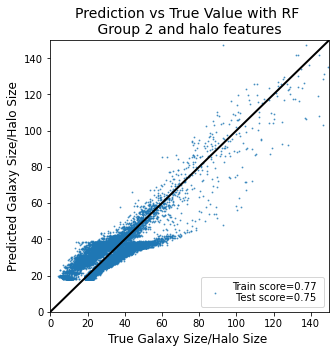

In [23]:
# Plot the figure
fig_prediction_2, ax = plt.subplots(figsize=(5, 5))

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_2, 2),round(scores_RF_2.mean(), 2) )
ax = plt.subplot()
ax.scatter(y_2, y_pred_RF_2, s=3, marker='.', alpha=0.7, label=label)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax.set_title('Prediction vs True Value with RF \n Group 2 and halo features ', fontsize=14)
ax.set_xlabel('True Galaxy Size/Halo Size ', fontsize=12)
ax.set_ylabel('Predicted Galaxy Size/Halo Size', fontsize=12)
ax.legend(loc='lower right')
# fig_prediction_2.savefig('Group2_RF_pred_vs_true_w_all_features.jpeg', dpi=500)
plt.show()

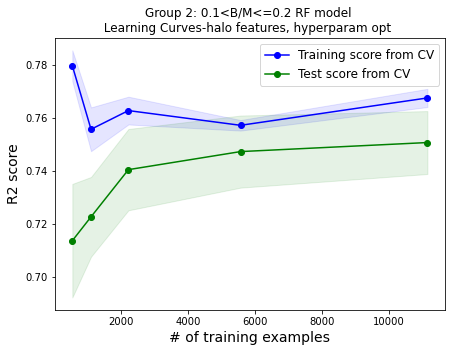

In [26]:
lc_2 = plot_learning_curve(best_RF_2, 'Group 2: 0.1<B/M<=0.2 RF model \n Learning Curves-halo features, hyperparam opt  ', X_2, y_2, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# lc_2.savefig('LC_RF_Group2_all_feat.jpeg', dpi=500)

#### Run the above with the 10 most important features only

## <font color='purple'> <a id =3> </a> <br>Group 3 Galaxies: 0.2< B/Mstar <=0.3

In [27]:
X_3 = df_3.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_3 = df_3.loc[:,'GalpropNormHalfRadius']

In [28]:
regr_RF = RandomForestRegressor(random_state=0)

# Use best params only: Best params, best score: 0.9650 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}

# number of trees in random forest
n_estimators = [20,50,100]
# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [2],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Grid search of parameters
rfr_grid_3 = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid_3.fit(X_3, y_3)

print('Best params, best score:', "{:.4f}".format(rfr_grid_3.best_score_), \
    rfr_grid_3.best_params_)
# define trainscore according to best model
best_RF_3=rfr_grid_3.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

best_RF_trainscore_3=rfr_grid_3.cv_results_['mean_train_score'][rfr_grid_3.best_index_]

# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_RF_3 = cross_val_predict(best_RF_3, X_3, y_3, cv = KFold(n_splits=5, shuffle=True, random_state=10))

# find prediction scores of each of the cross validation fold
scores_RF_3 = cross_val_score(best_RF_3, X_3, y_3, cv = KFold(n_splits=5, shuffle=True, random_state=10))
print("Group 3 RF Accuracy: %0.2f (+/- %0.2f)" % (scores_RF_3.mean(), scores_RF_3.std() * 2))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params, best score: 0.7529 {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 50}
Group 3 RF Accuracy: 0.75 (+/- 0.05)


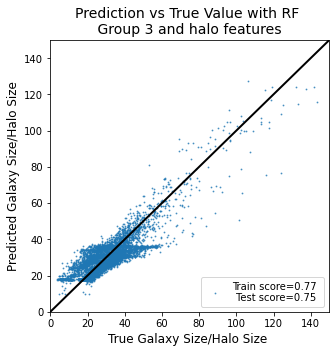

In [29]:
# Plot the figure
fig_prediction_3, ax = plt.subplots(figsize=(5, 5))

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_3, 2),round(scores_RF_3.mean(), 2) )
ax = plt.subplot()
ax.scatter(y_3, y_pred_RF_3, s=3, marker='.', alpha=0.7, label=label)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax.set_title('Prediction vs True Value with RF \n Group 3 and halo features ', fontsize=14)
ax.set_xlabel('True Galaxy Size/Halo Size ', fontsize=12)
ax.set_ylabel('Predicted Galaxy Size/Halo Size', fontsize=12)
ax.legend(loc='lower right')
# fig_prediction_3.savefig('Group3_RF_pred_vs_true_w_all_features.jpeg', dpi=500)
plt.show()

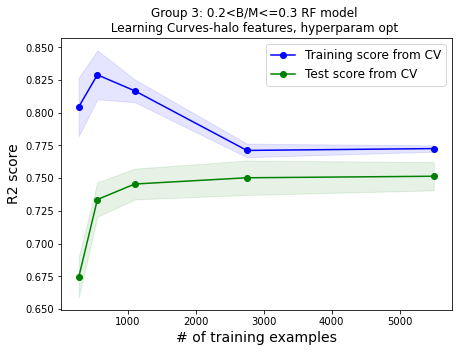

In [30]:
lc_3 = plot_learning_curve(best_RF_3, 'Group 3: 0.2<B/M<=0.3 RF model \n Learning Curves-halo features, hyperparam opt  ', X_3, y_3, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# lc_3.savefig('LC_RF_Group3_all_feat.jpeg', dpi=500)

#### Run the above with the 10 most important features only

## <font color='purple'> <a id =4> </a> <br>Group 4: 0.3< B/Mstar <=0.4

In [31]:
X_4 = df_4.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_4 = df_4.loc[:,'GalpropNormHalfRadius']

In [32]:
regr_RF = RandomForestRegressor(random_state=0)

# Use best params only: Best params, best score: 0.9031 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}

# number of trees in random forest
n_estimators = [20,50,100]
# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [2],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Grid search of parameters
rfr_grid_4 = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid_4.fit(X_4, y_4)

print('Best params, best score:', "{:.4f}".format(rfr_grid_4.best_score_), \
    rfr_grid_4.best_params_)
# define trainscore according to best model
best_RF_4=rfr_grid_4.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

best_RF_trainscore_4=rfr_grid_4.cv_results_['mean_train_score'][rfr_grid_4.best_index_]

# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_RF_4 = cross_val_predict(best_RF_4, X_4, y_4, cv = KFold(n_splits=5, shuffle=True, random_state=10))

# find prediction scores of each of the cross validation fold
scores_RF_4 = cross_val_score(best_RF_4, X_4, y_4, cv = KFold(n_splits=5, shuffle=True, random_state=10))
print("Group 4 RF Accuracy: %0.2f (+/- %0.2f)" % (scores_RF_4.mean(), scores_RF_4.std() * 2))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params, best score: 0.6719 {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}
Group 4 RF Accuracy: 0.67 (+/- 0.07)


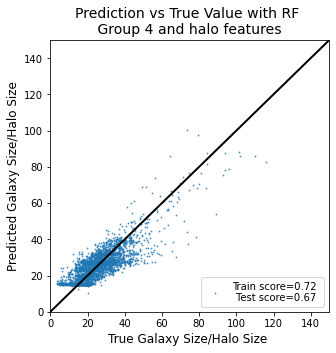

In [42]:
# Plot the figure
fig_prediction_4, ax = plt.subplots(figsize=(5, 5))

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_4, 2),round(scores_RF_4.mean(), 2) )
ax = plt.subplot()
ax.scatter(y_4, y_pred_RF_4, s=3, marker='.', alpha=0.7, label=label)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax.set_title('Prediction vs True Value with RF \n Group 4 and halo features ', fontsize=14)
ax.set_xlabel('True Galaxy Size/Halo Size ', fontsize=12)
ax.set_ylabel('Predicted Galaxy Size/Halo Size', fontsize=12)
ax.legend(loc='lower right')
# fig_prediction_4.savefig('Group4_RF_pred_vs_true_w_all_features.jpeg', dpi=500)
plt.show()

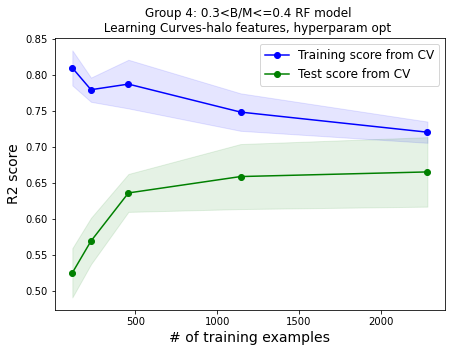

In [41]:
lc_4 = plot_learning_curve(best_RF_4, 'Group 4: 0.3<B/M<=0.4 RF model \n Learning Curves-halo features, hyperparam opt  ', X_4, y_4, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# lc_4.savefig('LC_RF_Group4_all_feat.jpeg', dpi=500)

#### Run the above with the 10 most important features only

## <font color='purple'> <a id =5> </a> <br>Group 5: 0.4< B/Mstar <=0.5

In [36]:
X_5 = df_5.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_5 = df_5.loc[:,'GalpropNormHalfRadius']

In [37]:
regr_RF = RandomForestRegressor(random_state=0)

# Use best params only: Best params, best score: 0.7607 {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50}

# number of trees in random forest
n_estimators = [20,50,100]
# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [2],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Grid search of parameters
rfr_grid_5 = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid_5.fit(X_5, y_5)

print('Best params, best score:', "{:.4f}".format(rfr_grid_5.best_score_), \
    rfr_grid_5.best_params_)
# define trainscore according to best model
best_RF_5=rfr_grid_5.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

best_RF_trainscore_5=rfr_grid_5.cv_results_['mean_train_score'][rfr_grid_5.best_index_]

# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_RF_5 = cross_val_predict(best_RF_5, X_5, y_5, cv = KFold(n_splits=5, shuffle=True, random_state=10))

# find prediction scores of each of the cross validation fold
scores_RF_5 = cross_val_score(best_RF_5, X_5, y_5, cv = KFold(n_splits=5, shuffle=True, random_state=10))
print("Group 5 RF Accuracy: %0.2f (+/- %0.2f)" % (scores_RF_5.mean(), scores_RF_5.std() * 2))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params, best score: 0.1344 {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 50}
Group 5 RF Accuracy: 0.15 (+/- 0.10)


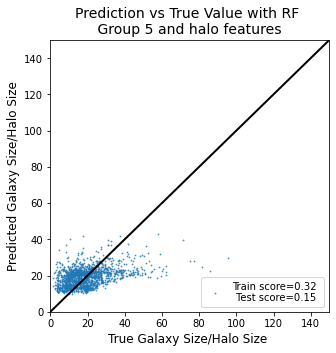

In [39]:
# Plot the figure
fig_prediction_5, ax = plt.subplots(figsize=(5, 5))

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_5, 2),round(scores_RF_5.mean(), 2) )
ax = plt.subplot()
ax.scatter(y_5, y_pred_RF_5, s=3, marker='.', alpha=0.7, label=label)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax.set_title('Prediction vs True Value with RF \n Group 5 and halo features ', fontsize=14)
ax.set_xlabel('True Galaxy Size/Halo Size ', fontsize=12)
ax.set_ylabel('Predicted Galaxy Size/Halo Size', fontsize=12)
ax.legend(loc='lower right')
# fig_prediction_5.savefig('Group5_RF_pred_vs_true_w_all_features.jpeg', dpi=500)
plt.show()

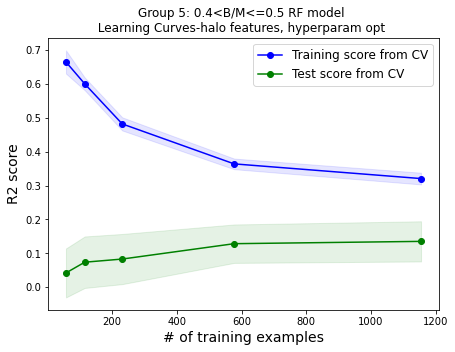

In [40]:
lc_5 = plot_learning_curve(best_RF_5, 'Group 5: 0.4<B/M<=0.5 RF model \n Learning Curves-halo features, hyperparam opt  ', X_5, y_5, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# lc_5.savefig('LC_RF_Group5_all_feat.jpeg', dpi=500)

#### Run the above with the 10 most important features only


## <font color='purple'> <a id =6> </a> <br> Group 6 (Elliptical) Galaxies:  B/Mstar > 0.5

In [43]:
X_6 = df_6.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_6 = df_6.loc[:,'GalpropNormHalfRadius']

In [44]:
regr_RF = RandomForestRegressor(random_state=0)

# Use best params only: Best params, best score: 0.7970 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}

# number of trees in random forest
n_estimators = [20,50,100]
# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [2],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Grid search of parameters
rfr_grid_6 = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid_6.fit(X_6, y_6)

print('Best params, best score:', "{:.4f}".format(rfr_grid_6.best_score_), \
    rfr_grid_6.best_params_)
# define trainscore according to best model
best_RF_6=rfr_grid_6.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

best_RF_trainscore_6=rfr_grid_6.cv_results_['mean_train_score'][rfr_grid_6.best_index_]

# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_RF_6 = cross_val_predict(best_RF_6, X_6, y_6, cv = KFold(n_splits=5, shuffle=True, random_state=10))

# find prediction scores of each of the cross validation fold
scores_RF_6 = cross_val_score(best_RF_6, X_6, y_6, cv = KFold(n_splits=5, shuffle=True, random_state=10))
print("Group 6 RF Accuracy: %0.2f (+/- %0.2f)" % (scores_RF_6.mean(), scores_RF_6.std() * 2))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params, best score: -0.0060 {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}
Group 6 RF Accuracy: 0.01 (+/- 0.03)


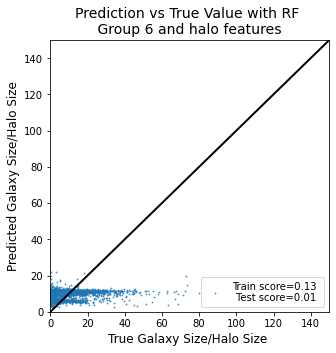

In [45]:
# Plot the figure
fig_prediction_6, ax = plt.subplots(figsize=(5, 5))

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_6, 2),round(scores_RF_6.mean(), 2) )
ax = plt.subplot()
ax.scatter(y_6, y_pred_RF_6, s=3, marker='.', alpha=0.7, label=label)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax.set_title('Prediction vs True Value with RF \n Group 6 and halo features ', fontsize=14)
ax.set_xlabel('True Galaxy Size/Halo Size ', fontsize=12)
ax.set_ylabel('Predicted Galaxy Size/Halo Size', fontsize=12)
ax.legend(loc='lower right')
# fig_prediction_6.savefig('Group6_RF_pred_vs_true_w_all_features.jpeg', dpi=500)
plt.show()

#### Run the above with the 10 most important features only

## Predictions vs True - The single figure with all the bins 

#### All features

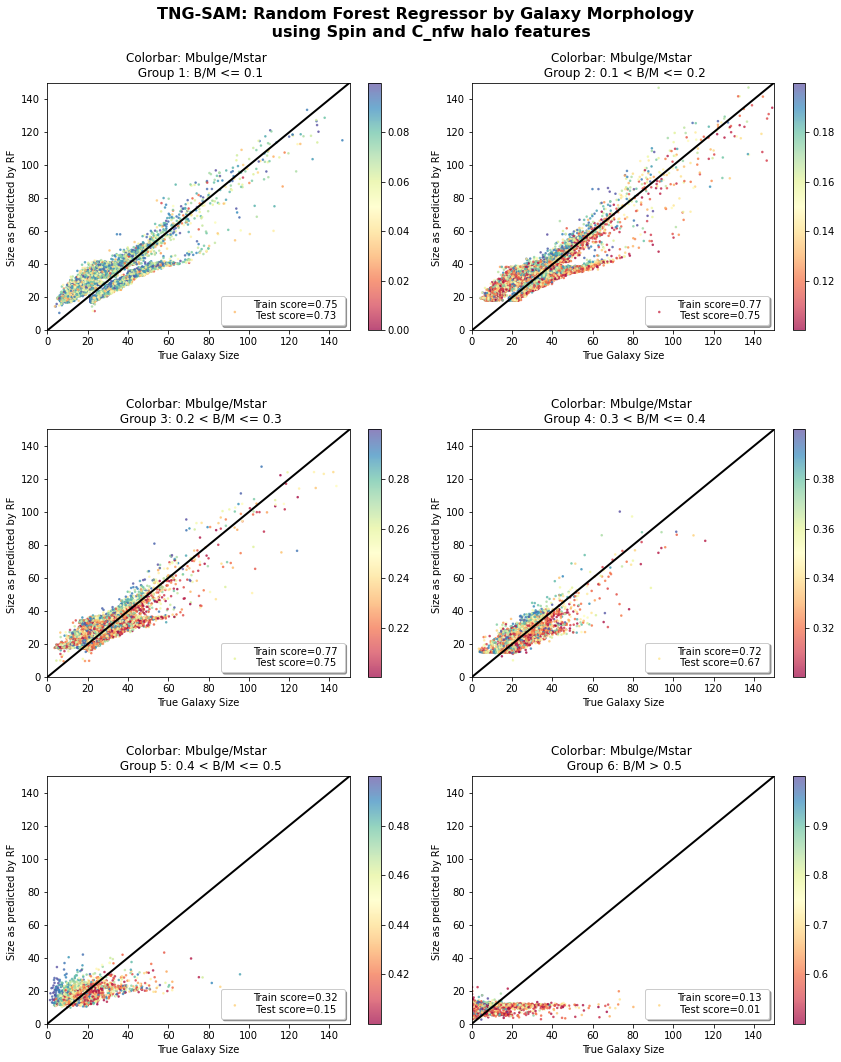

In [54]:
import matplotlib.cm as cm
import matplotlib.colors as norm
# from OpenCV import cv2 as cv #package OpenCV not installed

fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
fig_all.suptitle('TNG-SAM: Random Forest Regressor by Galaxy Morphology \n using Spin and C_nfw halo features', fontsize=16, fontweight='bold')


label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_1, 2),round(scores_RF_1.mean(), 2) )
fig_1 = ax1.scatter(df_1.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_1,
            c = df_1.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=label) #,label= label, vmin=-2, vmax=1.0)
# ax1.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_1[5]), size=12)
# ax1.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_1[6]), size=12)
ax1.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax1.set_xlim([0.0,150])
ax1.set_ylim([0.0,150])
ax1.set_title('Colorbar: Mbulge/Mstar \n Group 1: B/M <= 0.1')
ax1.set_xlabel('True Galaxy Size')
ax1.legend(loc = 'lower right', shadow=True)
ax1.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_1, ax=ax1)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_2, 2),round(scores_RF_2.mean(), 2) )
fig_2 = ax2.scatter(df_2.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_2,
            c = df_2.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
# ax2.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_2[5]), size=12)
# ax2.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_2[6]), size=12)
ax2.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax2.set_xlim([0.0,150])
ax2.set_ylim([0.0,150])
ax2.set_title('Colorbar: Mbulge/Mstar \n Group 2: 0.1 < B/M <= 0.2')
ax2.set_xlabel('True Galaxy Size')
ax2.legend(loc = 'lower right', shadow=True)
ax2.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_2, ax=ax2)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_3, 2),round(scores_RF_3.mean(), 2) )
fig_3 = ax3.scatter(df_3.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_3,
            c = df_3.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax3.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_3[5]), size=12)
# ax3.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_3[6]), size=12)
ax3.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax3.set_xlim([0.0,150])
ax3.set_ylim([0.0,150])
ax3.set_title('Colorbar: Mbulge/Mstar \n Group 3: 0.2 < B/M <= 0.3')
ax3.set_xlabel('True Galaxy Size')
ax3.legend(loc = 'lower right', shadow=True)
ax3.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_3, ax=ax3)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_4, 2),round(scores_RF_4.mean(), 2) )
fig_4 = ax4.scatter(df_4.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_4,
            c = df_4.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax4.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_4[5]), size=12)
# ax4.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_4[6]), size=12)
ax4.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax4.set_xlim([0.0,150])
ax4.set_ylim([0.0,150])
ax4.set_title('Colorbar: Mbulge/Mstar \n Group 4: 0.3 < B/M <= 0.4')
ax4.set_xlabel('True Galaxy Size')
ax4.legend(loc = 'lower right', shadow=True)
ax4.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_4, ax=ax4)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_5, 2),round(scores_RF_5.mean(), 2) )
fig_5 = ax5.scatter(df_5.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_5,
            c = df_5.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax5.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_5[5]), size=12)
# ax5.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_5[6]), size=12)
ax5.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax5.set_xlim([0.0,150])
ax5.set_ylim([0.0,150])
ax5.set_title('Colorbar: Mbulge/Mstar \n Group 5: 0.4 < B/M <= 0.5')
ax5.set_xlabel('True Galaxy Size')
ax5.legend(loc = 'lower right', shadow=True)
ax5.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_5, ax=ax5)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_6, 2),round(scores_RF_6.mean(), 2) )
fig_6 = ax6.scatter(df_6.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_6,
            c = df_6.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax6.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax6.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax6.set_xlim([0.0,150])
ax6.set_ylim([0.0,150])
ax6.set_title('Colorbar: Mbulge/Mstar \n Group 6: B/M > 0.5')
ax6.set_xlabel('True Galaxy Size')
ax6.legend(loc = 'lower right', shadow=True)
ax6.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_6, ax=ax6)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid2 = plt.GridSpec(2, 2)
# create_subtitle(fig2, grid2[0, ::], 'mHI')
# create_subtitle(fig2, grid2[1, ::], 'mH2')
fig_all.tight_layout()
fig_all.subplots_adjust(top=0.91, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG-SAM_RF_by_Galaxy_Morphology_w_Spin_Cnfw_features_BMratiocolor.jpeg", dpi=500)
plt.show()

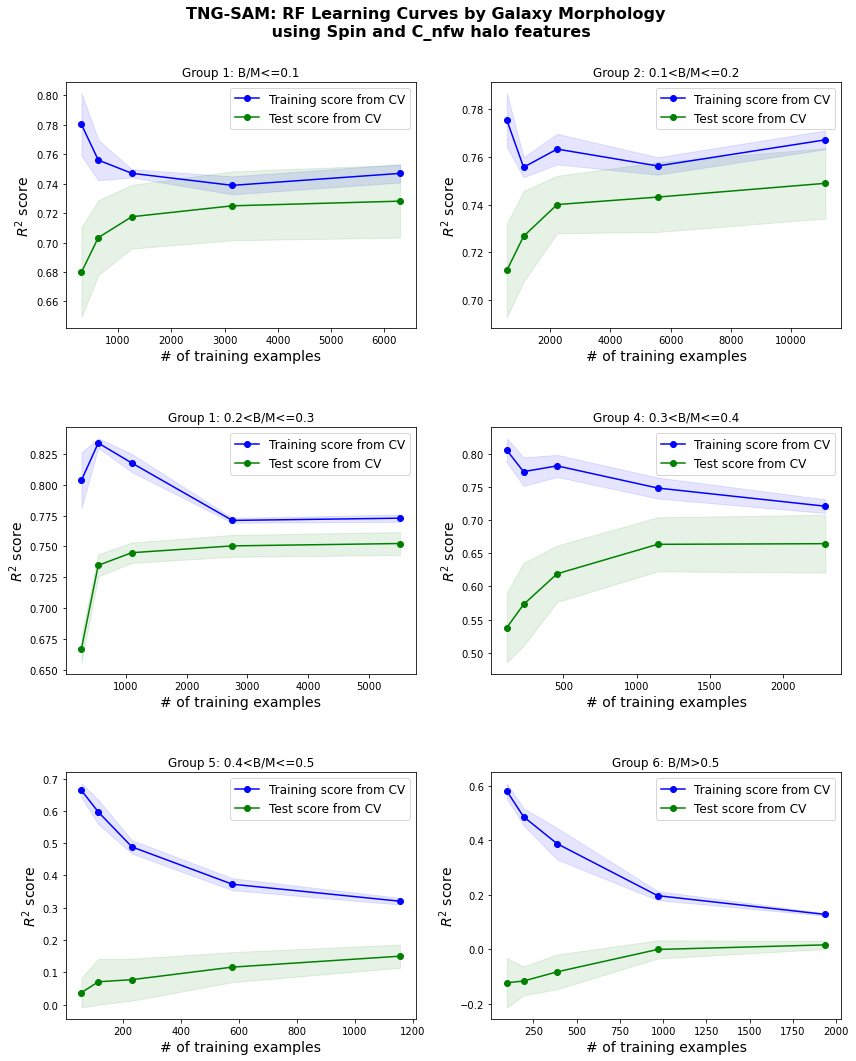

Elapsed time to plot RF learning curves for all morphologies: 4.311 seconds


In [56]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import sklearn as sklearn

# def plot_learning_curve_for_6_galaxy_morphologies(estimator, title, X, y, ylim=None, cv=5,
#                         n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
#     """
#     Generate a simple plot of the test and training learning curve.

#     Parameters
#     ----------
#     estimator : object type that implements the "fit" and "predict" methods
#         An object of that type which is cloned for each validation.

#     title : string
#         Title for the chart.

#     X : array-like, shape (n_samples, n_features)
#         Training vector, where n_samples is the number of samples and
#         n_features is the number of features.

#     y : array-like, shape (n_samples) or (n_samples, n_features), optional
#         Target relative to X for classification or regression;
#         None for unsupervised learning.

#     ylim : tuple, shape (ymin, ymax), optional
#         Defines minimum and maximum yvalues plotted.

#     cv : int, cross-validation generator or an iterable, optional
#         Determines the cross-validation splitting strategy.
#         Possible inputs for cv are:
#           - None, to use the default 3-fold cross-validation,
#           - integer, to specify the number of folds.
#           - :term:`CV splitter`,
#           - An iterable yielding (train, test) splits as arrays of indices.

#         For integer/None inputs, if ``y`` is binary or multiclass,
#         :class:`StratifiedKFold` used. If the estimator is not a classifier
#         or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

#         Refer :ref:`User Guide <cross_validation>` for the various
#         cross-validators that can be used here.

#     n_jobs : int or None, optional (default=None)
#         Number of jobs to run in parallel.
#         ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
#         ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
#         for more details.

#     train_sizes : array-like, shape (n_ticks,), dtype float or int
#         Relative or absolute numbers of training examples that will be used to
#         generate the learning curve. If the dtype is float, it is regarded as a
#         fraction of the maximum size of the training set (that is determined
#         by the selected validation method), i.e. it has to be within (0, 1].
#         Otherwise it is interpreted as absolute sizes of the training sets.
#         Note that for classification the number of samples usually have to
#         be big enough to contain at least one sample from each class.
#         (default: np.linspace(0.1, 1.0, 5))
#     """

start_time = time.time()
lc_fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
lc_fig_all.suptitle('TNG-SAM: RF Learning Curves by Galaxy Morphology \n using Spin and C_nfw halo features', fontsize=16, fontweight='bold')

# Learning Curve Group 1
ax1.set_title('Group 1: B/M<=0.1')
ylim = None
if ylim is not None:
    ax1.set_ylim(*ylim)
ax1.set_xlabel("# of training examples",fontsize = 14)

ax1.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_1 = scaler.fit_transform(X_1)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF_1, X_1, y_1, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax1.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax1.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax1.legend(loc="best",fontsize = 12)

# Learning Curve Group 2
ax2.set_title('Group 2: 0.1<B/M<=0.2')
ylim = None
if ylim is not None:
    ax2.set_ylim(*ylim)
ax2.set_xlabel("# of training examples",fontsize = 14)

ax2.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_2 = scaler.fit_transform(X_2)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF_2, X_2, y_2, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax2.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax2.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax2.legend(loc="best",fontsize = 12)

# Learning Curve Group 3
ax3.set_title('Group 1: 0.2<B/M<=0.3')
ylim = None
if ylim is not None:
    ax3.set_ylim(*ylim)
ax3.set_xlabel("# of training examples",fontsize = 14)

ax3.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_3 = scaler.fit_transform(X_3)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF_3, X_3, y_3, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax3.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax3.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax3.legend(loc="best",fontsize = 12)

# Learning Curve Group 4
ax4.set_title('Group 4: 0.3<B/M<=0.4')
ylim = None
if ylim is not None:
    ax4.set_ylim(*ylim)
ax4.set_xlabel("# of training examples",fontsize = 14)

ax4.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_4 = scaler.fit_transform(X_4)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF_4, X_4, y_4, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax4.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax4.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax4.legend(loc="best",fontsize = 12)

# Learning Curve Group 5
ax5.set_title('Group 5: 0.4<B/M<=0.5')
ylim = None
if ylim is not None:
    ax5.set_ylim(*ylim)
ax5.set_xlabel("# of training examples",fontsize = 14)

ax5.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_5 = scaler.fit_transform(X_5)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF_5, X_5, y_5, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax5.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax5.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax5.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax5.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax5.legend(loc="best",fontsize = 12)

# Learning Curve Group 6
ax6.set_title('Group 6: B/M>0.5')
ylim = None
if ylim is not None:
    ax6.set_ylim(*ylim)
ax6.set_xlabel("# of training examples",fontsize = 14)

ax6.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_6 = scaler.fit_transform(X_6)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF_6, X_6, y_6, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax6.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax6.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax6.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax6.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax6.legend(loc="best",fontsize = 12)

lc_fig_all.tight_layout()
lc_fig_all.subplots_adjust(top=0.91, hspace=0.4) #, wspace=0.4)

plt.savefig("TNG-SAM_LearningCurves_RF_by_Galaxy_Morphology_w_Spin_Cnfw_features.jpeg", dpi=500)
plt.show()
elapsed_time = time.time() - start_time
# print(f"Elapsed time to plot RF learning curves for all morphologies: {elapsed_time:.3f} seconds")




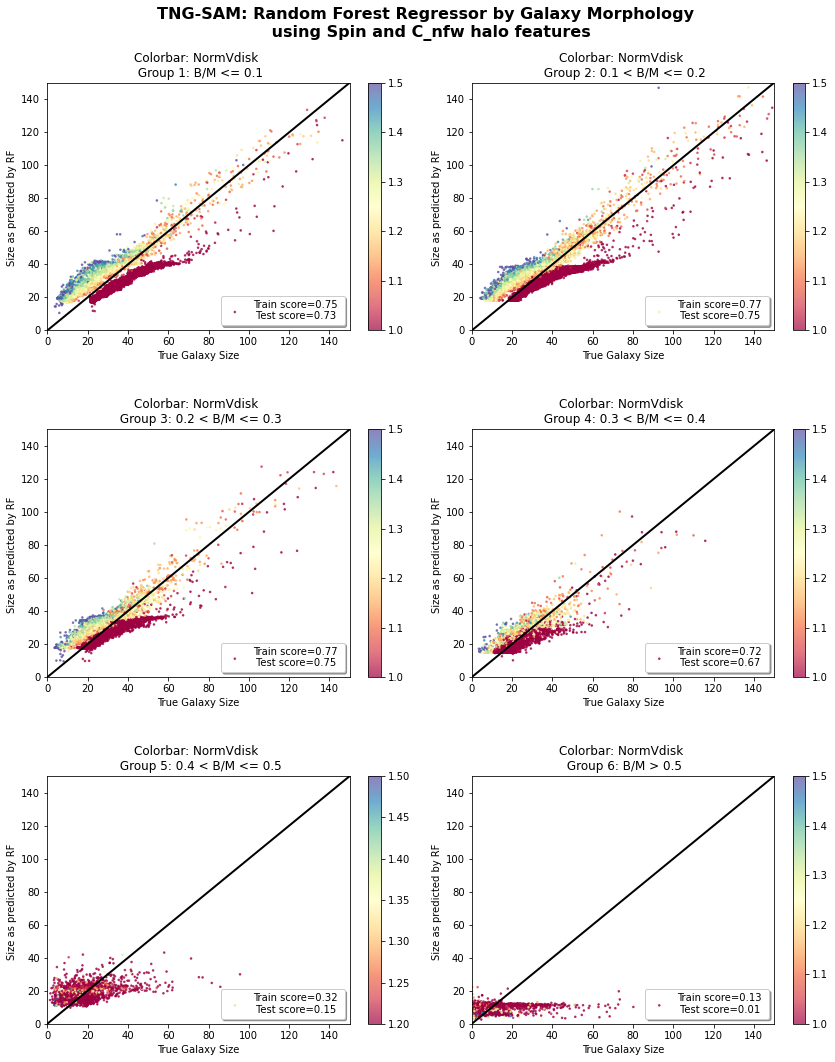

In [53]:
import matplotlib.cm as cm
import matplotlib.colors as norm
# from OpenCV import cv2 as cv #package OpenCV not installed

fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
fig_all.suptitle('TNG-SAM: Random Forest Regressor by Galaxy Morphology \n using Spin and C_nfw halo features', fontsize=16, fontweight='bold')


label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_1, 2),round(scores_RF_1.mean(), 2) )
fig_1 = ax1.scatter(df_1.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_1,
            c = df_1.loc[:,'GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=label, vmin=1.0, vmax=1.5)
# ax1.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_1[5]), size=12)
# ax1.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_1[6]), size=12)
ax1.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax1.set_xlim([0.0,150])
ax1.set_ylim([0.0,150])
ax1.set_title('Colorbar: NormVdisk \n Group 1: B/M <= 0.1')
ax1.set_xlabel('True Galaxy Size')
ax1.legend(loc = 'lower right', shadow=True)
ax1.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_1, ax=ax1)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_2, 2),round(scores_RF_2.mean(), 2) )
fig_2 = ax2.scatter(df_2.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_2,
            c = df_2.loc[:,'GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= label, vmin=1.0, vmax=1.5)
# ax2.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_2[5]), size=12)
# ax2.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_2[6]), size=12)
ax2.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax2.set_xlim([0.0,150])
ax2.set_ylim([0.0,150])
ax2.set_title('Colorbar: NormVdisk \n Group 2: 0.1 < B/M <= 0.2')
ax2.set_xlabel('True Galaxy Size')
ax2.legend(loc = 'lower right', shadow=True)
ax2.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_2, ax=ax2)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_3, 2),round(scores_RF_3.mean(), 2) )
fig_3 = ax3.scatter(df_3.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_3,
            c = df_3.loc[:,'GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label, vmin=1.0, vmax=1.5)
# ax3.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_3[5]), size=12)
# ax3.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_3[6]), size=12)
ax3.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax3.set_xlim([0.0,150])
ax3.set_ylim([0.0,150])
ax3.set_title('Colorbar: NormVdisk \n Group 3: 0.2 < B/M <= 0.3')
ax3.set_xlabel('True Galaxy Size')
ax3.legend(loc = 'lower right', shadow=True)
ax3.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_3, ax=ax3)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_4, 2),round(scores_RF_4.mean(), 2) )
fig_4 = ax4.scatter(df_4.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_4,
            c = df_4.loc[:,'GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label, vmin=1.0, vmax=1.5)
# ax4.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_4[5]), size=12)
# ax4.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_4[6]), size=12)
ax4.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax4.set_xlim([0.0,150])
ax4.set_ylim([0.0,150])
ax4.set_title('Colorbar: NormVdisk \n Group 4: 0.3 < B/M <= 0.4')
ax4.set_xlabel('True Galaxy Size')
ax4.legend(loc = 'lower right', shadow=True)
ax4.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_4, ax=ax4)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_5, 2),round(scores_RF_5.mean(), 2) )
fig_5 = ax5.scatter(df_5.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_5,
            c = df_5.loc[:,'GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label, vmin=1.2, vmax=1.5)
# ax5.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_5[5]), size=12)
# ax5.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_5[6]), size=12)
ax5.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax5.set_xlim([0.0,150])
ax5.set_ylim([0.0,150])
ax5.set_title('Colorbar: NormVdisk \n Group 5: 0.4 < B/M <= 0.5')
ax5.set_xlabel('True Galaxy Size')
ax5.legend(loc = 'lower right', shadow=True)
ax5.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_5, ax=ax5)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_6, 2),round(scores_RF_6.mean(), 2) )
fig_6 = ax6.scatter(df_6.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_6,
            c = df_6.loc[:,'GalpropNormVdisk'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label, vmin=1.0, vmax=1.5)
# ax6.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax6.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax6.set_xlim([0.0,150])
ax6.set_ylim([0.0,150])
ax6.set_title('Colorbar: NormVdisk \n Group 6: B/M > 0.5')
ax6.set_xlabel('True Galaxy Size')
ax6.legend(loc = 'lower right', shadow=True)
ax6.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_6, ax=ax6)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid2 = plt.GridSpec(2, 2)
# create_subtitle(fig2, grid2[0, ::], 'mHI')
# create_subtitle(fig2, grid2[1, ::], 'mH2')
fig_all.tight_layout()
fig_all.subplots_adjust(top=0.91, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG-SAM_RF_by_Galaxy_Morphology_w_Spin_Cnfw_features_vdiskcolor.jpeg", dpi=500)
plt.show()

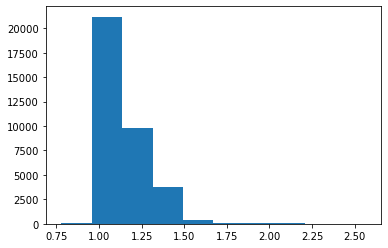

In [49]:
plt.hist(df_normalized_31.loc[:, 'GalpropNormVdisk'])
plt.show()

### Using the 10 most important features (different best 10 features for each bin)

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as norm
# from OpenCV import cv2 as cv #package OpenCV not installed

fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
fig_all.suptitle('TNG-SAM: Random Fores Regressor by Galaxy Morphology \n using 10 important features, with hyperparameter optimization', fontsize=16, fontweight='bold')


label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_1, 2),round(scores_RF_1.mean(), 2) )
fig_1 = ax1.scatter(df_1.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_1,
            c = df_1.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=label) #,label= label, vmin=-2, vmax=1.0)
# ax1.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_1[5]), size=12)
# ax1.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_1[6]), size=12)
ax1.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax1.set_xlim([0.0,150])
ax1.set_ylim([0.0,150])
ax1.set_title('Colorbar: Mbulge/Mstar \n Group 1: B/M <= 0.1')
ax1.set_xlabel('True Galaxy Size')
ax1.legend(loc = 'lower right', shadow=True)
ax1.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_1, ax=ax1)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_2, 2),round(scores_RF_2.mean(), 2) )
fig_2 = ax2.scatter(df_2.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_2,
            c = df_2.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
# ax2.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_2[5]), size=12)
# ax2.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_2[6]), size=12)
ax2.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax2.set_xlim([0.0,150])
ax2.set_ylim([0.0,150])
ax2.set_title('Colorbar: Mbulge/Mstar \n Group 2: 0.1 < B/M <= 0.2')
ax2.set_xlabel('True Galaxy Size')
ax2.legend(loc = 'lower right', shadow=True)
ax2.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_2, ax=ax2)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_3, 2),round(scores_RF_3.mean(), 2) )
fig_3 = ax3.scatter(df_3.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_3,
            c = df_3.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax3.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_3[5]), size=12)
# ax3.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_3[6]), size=12)
ax3.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax3.set_xlim([0.0,150])
ax3.set_ylim([0.0,150])
ax3.set_title('Colorbar: Mbulge/Mstar \n Group 3: 0.2 < B/M <= 0.3')
ax3.set_xlabel('True Galaxy Size')
ax3.legend(loc = 'lower right', shadow=True)
ax3.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_3, ax=ax3)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_4, 2),round(scores_RF_4.mean(), 2) )
fig_4 = ax4.scatter(df_4.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_4,
            c = df_4.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax4.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_4[5]), size=12)
# ax4.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_4[6]), size=12)
ax4.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax4.set_xlim([0.0,150])
ax4.set_ylim([0.0,150])
ax4.set_title('Colorbar: Mbulge/Mstar \n Group 4: 0.3 < B/M <= 0.4')
ax4.set_xlabel('True Galaxy Size')
ax4.legend(loc = 'lower right', shadow=True)
ax4.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_4, ax=ax4)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_5, 2),round(scores_RF_5.mean(), 2) )
fig_5 = ax5.scatter(df_5.loc[:, 'GalpropNormHalfRadius'], y_pred_RF_5,
            c = df_5.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax5.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_5[5]), size=12)
# ax5.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_5[6]), size=12)
ax5.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax5.set_xlim([0.0,150])
ax5.set_ylim([0.0,150])
ax5.set_title('Colorbar: Mbulge/Mstar \n Group 5: 0.4 < B/M <= 0.5')
ax5.set_xlabel('True Galaxy Size')
ax5.legend(loc = 'lower right', shadow=True)
ax5.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_5, ax=ax5)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore_6, 2),round(scores_RF_6.mean(), 2) )
fig_6 = ax6.scatter(df_6.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_6,
            c = df_6.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax6.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax6.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax6.set_xlim([0.0,150])
ax6.set_ylim([0.0,150])
ax6.set_title('Colorbar: Mbulge/Mstar \n Group 6: B/M > 0.5')
ax6.set_xlabel('True Galaxy Size')
ax6.legend(loc = 'lower right', shadow=True)
ax6.set_ylabel('Size as predicted by RF ')
fig_all.colorbar(fig_6, ax=ax6)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid2 = plt.GridSpec(2, 2)
# create_subtitle(fig2, grid2[0, ::], 'mHI')
# create_subtitle(fig2, grid2[1, ::], 'mH2')
fig_all.tight_layout()
fig_all.subplots_adjust(top=0.91, hspace=0.4) #, wspace=0.4)

plt.savefig("TTNG-SAM_RF_by_Galaxy_Morphology_w_hyperparam_opt_10imp_features.jpeg", dpi=500)
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import sklearn as sklearn

# def plot_learning_curve_for_6_galaxy_morphologies(estimator, title, X, y, ylim=None, cv=5,
#                         n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
#     """
#     Generate a simple plot of the test and training learning curve.

#     Parameters
#     ----------
#     estimator : object type that implements the "fit" and "predict" methods
#         An object of that type which is cloned for each validation.

#     title : string
#         Title for the chart.

#     X : array-like, shape (n_samples, n_features)
#         Training vector, where n_samples is the number of samples and
#         n_features is the number of features.

#     y : array-like, shape (n_samples) or (n_samples, n_features), optional
#         Target relative to X for classification or regression;
#         None for unsupervised learning.

#     ylim : tuple, shape (ymin, ymax), optional
#         Defines minimum and maximum yvalues plotted.

#     cv : int, cross-validation generator or an iterable, optional
#         Determines the cross-validation splitting strategy.
#         Possible inputs for cv are:
#           - None, to use the default 3-fold cross-validation,
#           - integer, to specify the number of folds.
#           - :term:`CV splitter`,
#           - An iterable yielding (train, test) splits as arrays of indices.

#         For integer/None inputs, if ``y`` is binary or multiclass,
#         :class:`StratifiedKFold` used. If the estimator is not a classifier
#         or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

#         Refer :ref:`User Guide <cross_validation>` for the various
#         cross-validators that can be used here.

#     n_jobs : int or None, optional (default=None)
#         Number of jobs to run in parallel.
#         ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
#         ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
#         for more details.

#     train_sizes : array-like, shape (n_ticks,), dtype float or int
#         Relative or absolute numbers of training examples that will be used to
#         generate the learning curve. If the dtype is float, it is regarded as a
#         fraction of the maximum size of the training set (that is determined
#         by the selected validation method), i.e. it has to be within (0, 1].
#         Otherwise it is interpreted as absolute sizes of the training sets.
#         Note that for classification the number of samples usually have to
#         be big enough to contain at least one sample from each class.
#         (default: np.linspace(0.1, 1.0, 5))
#     """

start_time = time.time()
lc_fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
lc_fig_all.suptitle('TNG-SAM: RF Learning Curves by Galaxy Morphology \n using 10 most important features', fontsize=16, fontweight='bold')

# Learning Curve Group 1
ax1.set_title('Group 1: B/M<=0.1')
ylim = None
if ylim is not None:
    ax1.set_ylim(*ylim)
ax1.set_xlabel("# of training examples",fontsize = 14)

ax1.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_1 = scaler.fit_transform(X_1)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF_1, X_1, y_1, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax1.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax1.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax1.legend(loc="best",fontsize = 12)

# Learning Curve Group 2
ax2.set_title('Group 2: 0.1<B/M<=0.2')
ylim = None
if ylim is not None:
    ax2.set_ylim(*ylim)
ax2.set_xlabel("# of training examples",fontsize = 14)

ax2.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_2 = scaler.fit_transform(X_2)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF_2, X_2, y_2, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax2.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax2.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax2.legend(loc="best",fontsize = 12)

# Learning Curve Group 3
ax3.set_title('Group 1: 0.2<B/M<=0.3')
ylim = None
if ylim is not None:
    ax3.set_ylim(*ylim)
ax3.set_xlabel("# of training examples",fontsize = 14)

ax3.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_3 = scaler.fit_transform(X_3)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF_3, X_3, y_3, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax3.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax3.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax3.legend(loc="best",fontsize = 12)

# Learning Curve Group 4
ax4.set_title('Group 4: 0.3<B/M<=0.4')
ylim = None
if ylim is not None:
    ax4.set_ylim(*ylim)
ax4.set_xlabel("# of training examples",fontsize = 14)

ax4.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_4 = scaler.fit_transform(X_4)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF_4, X_4, y_4, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax4.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax4.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax4.legend(loc="best",fontsize = 12)

# Learning Curve Group 5
ax5.set_title('Group 5: 0.4<B/M<=0.5')
ylim = None
if ylim is not None:
    ax5.set_ylim(*ylim)
ax5.set_xlabel("# of training examples",fontsize = 14)

ax5.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_5 = scaler.fit_transform(X_5)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF_5, X_5, y_5, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax5.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax5.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax5.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax5.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax5.legend(loc="best",fontsize = 12)

# Learning Curve Group 6
ax6.set_title('Group 6: B/M>0.5')
ylim = None
if ylim is not None:
    ax6.set_ylim(*ylim)
ax6.set_xlabel("# of training examples",fontsize = 14)

ax6.set_ylabel("$R^{2}$ score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_6 = scaler.fit_transform(X_6)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_RF_6, X_6, y_6, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax6.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax6.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax6.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax6.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax6.legend(loc="best",fontsize = 12)

lc_fig_all.tight_layout()
lc_fig_all.subplots_adjust(top=0.91, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG-SAM_LearningCurves_RF_by_Galaxy_Morphology_w_10imp_features.jpeg", dpi=500)
plt.show()
elapsed_time = time.time() - start_time
print(f"Elapsed time to plot RF learning curves for all morphologies: {elapsed_time:.3f} seconds")



